In [155]:
# importing neccessary library
import os, cv2 , glob , shutil
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet # importing xml.etree for reading the xml files

import torch
# importing tensorflow libraries
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [138]:
annotation_path = './VOC2007/Annotations/' # base directory for xml files

xmls = glob.glob(f'{annotation_path}/*.xml') # load all the xml files 

df= dict(filepath=[],img_path=[],xmin=[],xmax=[],ymin=[],ymax=[])#dictionary containing xml & coresponding image info

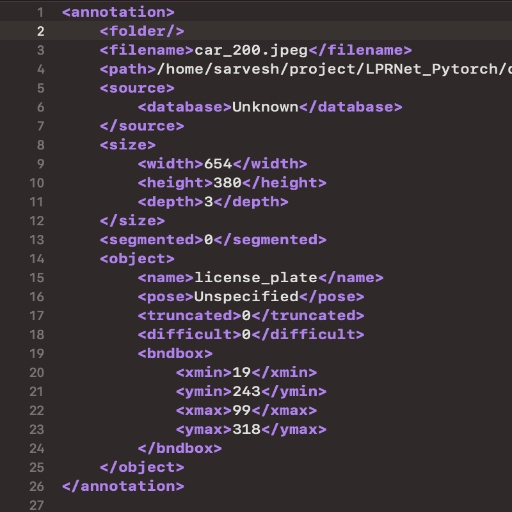

Structure of the xml file contains the target coordinates in bndbox , width & heigth info in size 

In [139]:
for filename in xmls:
    info = xet.parse(filename)
    root = info.getroot()
    
    member_object = root.find('object')
    labels_info = member_object.find('bndbox') # labels_info contains the box coordinates
    img_name = root.find('filename').text # for filename of the image
    # the four points are the coordinates of rectangles left top and right bottom corners    
    xmin = int(labels_info.find('xmin').text) 
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    df['filepath'].append(filename)
    df['xmin'].append(xmin)
    df['xmax'].append(xmax)
    df['ymin'].append(ymin)
    df['ymax'].append(ymax)
    df['img_path'].append(f'./VOC2007/JPEGImages/{img_name.split(".")[0]}.jpg')

In [140]:
xmin,xmax,ymin,ymax = df['xmin'][0] , df['xmax'][0],df['ymin'][0],df['xmax'][0] # get the coordinate of the box
xmin,xmax,ymin,ymax

(243, 285, 184, 285)

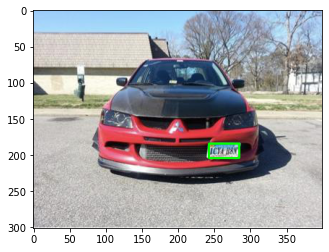

In [141]:
xmin,xmax,ymin,ymax = df['xmin'][0] , df['xmax'][0],df['ymin'][0],df['ymax'][0] # get the coordinate of the box
# draw a yellow colored rectangle of thickness 3 
image = cv2.rectangle(plt.imread(df['img_path'][0]),(xmin,ymin),(xmax,ymax),(0,255,0),2)
plt.imshow(image)

In [142]:
# convert above dictionary to dataframe
dataframe = pd.DataFrame(df)

In [143]:
# create new columns containg the height and width info 
dataframe['height'] = dataframe['img_path'].apply(lambda x:cv2.imread(x).shape[0])
dataframe['width'] = dataframe['img_path'].apply(lambda x:cv2.imread(x).shape[1])

In [144]:
"""Yolov5 takes input as the centerX and centerY and the width and height of each , the directory of the images
folder and corresponding coordinates in a txt file in the same directory"""

dataframe['center_x'] = (dataframe['xmax'] + dataframe['xmin'])/(2*dataframe['width'])
dataframe['center_y'] = (dataframe['ymax'] + dataframe['ymin'])/(2*dataframe['height'])

dataframe['bb_width'] = (dataframe['xmax'] - dataframe['xmin'])/dataframe['width']
dataframe['bb_height'] = (dataframe['ymax'] - dataframe['ymin'])/dataframe['height']

In [145]:
dataframe

,filepath,img_path,xmin,xmax,ymin,ymax,height,width,center_x,center_y,bb_width,bb_height
0,./VOC2007/Annotations/car_499.xml,./VOC2007/JPEGImages/car_499.jpg,243,285,184,204,301,400,0.660000,0.644518,0.105000,0.066445
1,./VOC2007/Annotations/car_328.xml,./VOC2007/JPEGImages/car_328.jpg,269,317,170,189,253,400,0.732500,0.709486,0.120000,0.075099
2,./VOC2007/Annotations/car_314.xml,./VOC2007/JPEGImages/car_314.jpg,229,309,151,178,270,400,0.672500,0.609259,0.200000,0.100000
3,./VOC2007/Annotations/car_472.xml,./VOC2007/JPEGImages/car_472.jpg,152,247,145,167,225,400,0.498750,0.693333,0.237500,0.097778
4,./VOC2007/Annotations/car_466.xml,./VOC2007/JPEGImages/car_466.jpg,253,284,163,177,225,400,0.671250,0.755556,0.077500,0.062222
...,...,...,...,...,...,...,...,...,...,...,...,...
664,./VOC2007/Annotations/car_443.xml,./VOC2007/JPEGImages/car_443.jpg,95,164,184,206,300,400,0.323750,0.650000,0.172500,0.073333
665,./VOC2007/Annotations/car_457.xml,./VOC2007/JPEGImages/car_457.jpg,142,188,168,182,265,400,0.412500,0.660377,0.115000,0.052830
666,./VOC2007/Annotations/car_331.xml,./VOC2007/JPEGImages/car_331.jpg,175,250,210,247,319,400,0.531250,0.716301,0.187500,0.115987
667,./VOC2007/Annotations/car_480.xml,./VOC2007/JPEGImages/car_480.jpg,128,465,174,235,450,600,0.494167,0.454444,0.561667,0.135556


In [146]:
# Keeping important columns only 
yolo_df = dataframe[['filepath', 'center_x', 'center_y', 'bb_width', 'bb_height']]
# Performing 85-15 split
val_size = int(0.15 * len(dataframe))

df_train, df_val = train_test_split(yolo_df, test_size=val_size,shuffle=True)
df_test = df_train[:30]
df_train = df_train[30:]

In [148]:
df_train.shape , df_val.shape, df_test.shape

((539, 5), (100, 5), (30, 5))

In [149]:
"""After split the indexes get changed, reindexing the indexes from 0"""
df_train.set_index(keys=np.arange(df_train.shape[0]),inplace=True)

In [150]:
df_train

,filepath,center_x,center_y,bb_width,bb_height
0,./VOC2007/Annotations/car_57.xml,0.294558,0.391304,0.189116,0.098299
1,./VOC2007/Annotations/car_461.xml,0.441667,0.729167,0.129167,0.069444
2,./VOC2007/Annotations/car_384.xml,0.646000,0.546642,0.388000,0.167910
3,./VOC2007/Annotations/car_291.xml,0.506250,0.298333,0.272500,0.190000
4,./VOC2007/Annotations/car_167.xml,0.670000,0.611014,0.453846,0.173077
...,...,...,...,...,...
534,./VOC2007/Annotations/car_466.xml,0.671250,0.755556,0.077500,0.062222
535,./VOC2007/Annotations/car_294.xml,0.685615,0.737603,0.118329,0.136364
536,./VOC2007/Annotations/car_365.xml,0.520000,0.528889,0.485000,0.480000
537,./VOC2007/Annotations/car_179.xml,0.482910,0.700000,0.206055,0.086131


In [151]:
yolo_df

,filepath,center_x,center_y,bb_width,bb_height
0,./VOC2007/Annotations/car_499.xml,0.660000,0.644518,0.105000,0.066445
1,./VOC2007/Annotations/car_328.xml,0.732500,0.709486,0.120000,0.075099
2,./VOC2007/Annotations/car_314.xml,0.672500,0.609259,0.200000,0.100000
3,./VOC2007/Annotations/car_472.xml,0.498750,0.693333,0.237500,0.097778
4,./VOC2007/Annotations/car_466.xml,0.671250,0.755556,0.077500,0.062222
...,...,...,...,...,...
664,./VOC2007/Annotations/car_443.xml,0.323750,0.650000,0.172500,0.073333
665,./VOC2007/Annotations/car_457.xml,0.412500,0.660377,0.115000,0.052830
666,./VOC2007/Annotations/car_331.xml,0.531250,0.716301,0.187500,0.115987
667,./VOC2007/Annotations/car_480.xml,0.494167,0.454444,0.561667,0.135556


In [157]:
train_path = os.path.join('Images', 'train')
val_path = os.path.join('Images','val')
test_path = os.path.join('Images', 'test')
images_path = './VOC2007/JPEGImages/'

if not os.path.exists(train_path):
    os.makedirs(train_path)
    print('Made folder for train set')

if not os.path.exists(val_path):
    os.makedirs(val_path)
    print('Made folder for val set')

if not os.path.exists(test_path):
    os.makedirs(test_path)
    print('Made folder for test set')

In [161]:
print('Moving images for train set')
for _, row  in tqdm(df_train.iterrows()):
    annotation_path = row['filepath']
    image_name = os.path.split(annotation_path)[-1].replace('.xml','')
    image_src = os.path.join(images_path, f'{image_name}.jpg')
    image_dst = os.path.join(train_path, f'{image_name}.jpg')
    shutil.copy2(image_src, image_dst)
    label_text = f"0 {row['center_x']} {row['center_y']} {row['bb_width']} {row['bb_height']}"
    with open(os.path.join(train_path, f'{image_name}.txt'), 'w') as f:
        f.write(label_text)
print('Done moving images for train set')

print('Moving images for val set')
for _, row  in tqdm(df_val.iterrows()):
    annotation_path = row['filepath']
    image_name = os.path.split(annotation_path)[-1].replace('.xml','')
    image_src = os.path.join(images_path, f'{image_name}.jpg')
    image_dst = os.path.join(val_path, f'{image_name}.jpg')
    shutil.copy2(image_src, image_dst)
    label_text = f"0 {row['center_x']} {row['center_y']} {row['bb_width']} {row['bb_height']}"
    with open(os.path.join(val_path, f'{image_name}.txt'), 'w') as f:
        f.write(label_text)
print('Done moving images for val set')

print('Moving images for test set')
for _, row  in tqdm(df_test.iterrows()):
    annotation_path = row['filepath']
    image_name = os.path.split(annotation_path)[-1].replace('.xml','')
    image_src = os.path.join(images_path, f'{image_name}.jpg')
    image_dst = os.path.join(test_path, f'{image_name}.jpg')
    shutil.copy2(image_src, image_dst)
    label_text = f"0 {row['center_x']} {row['center_y']} {row['bb_width']} {row['bb_height']}"
    with open(os.path.join(test_path, f'{image_name}.txt'), 'w') as f:
        f.write(label_text)
print('Done moving images for test set')

Moving images for train set


539it [00:00, 1715.29it/s]


Done moving images for train set
Moving images for val set


100it [00:00, 1647.14it/s]


Done moving images for val set
Moving images for test set


30it [00:00, 1905.23it/s]

Done moving images for test set


In [166]:
! git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 12472, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 12472 (delta 13), reused 1 (delta 0), pack-reused 12446
Receiving objects: 100% (12472/12472), 12.43 MiB | 1.58 MiB/s, done.
Resolving deltas: 100% (8544/8544), done.


In [167]:
! pip install -r yolov5/requirements.txt

In [170]:
data = {
    'names':['License Plate'],
    'nc':1,
    'train':os.path.abspath(train_path),
    'val':os.path.abspath(val_path)
}

with open('data.yaml', 'w') as f:
    yaml.dump(data, f)

In [171]:
! python ./yolov5/train.py --data ./data.yaml  --batch-size 8  --epochs 100 --weights yolov5/yolov5s.pt

train: weights=yolov5/yolov5s.pt, cfg=, data=./data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=8, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-360-g84e7748 Python-3.8.13 torch-1.12.0 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0


     Epoch   gpu_mem       box       obj       cls    labels  img_size
     34/99        0G   0.03054  0.008057         0         5       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all        101        101      0.951       0.97      0.965      0.647

     Epoch   gpu_mem       box       obj       cls    labels  img_size
     35/99        0G   0.03127  0.008097         0         6       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all        101        101      0.954       0.98      0.981      0.648

     Epoch   gpu_mem       box       obj       cls    labels  img_size
     36/99        0G   0.02971  0.008041         0        12       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all        101        101      0.951       0.99      0.975       0.63

     Epoch   gpu_mem       box      


     Epoch   gpu_mem       box       obj       cls    labels  img_size
     85/99        0G    0.0203  0.006474         0         4       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all        101        101      0.979       0.97       0.99      0.775

     Epoch   gpu_mem       box       obj       cls    labels  img_size
     86/99        0G   0.02001  0.006372         0        11       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all        101        101      0.977       0.98      0.988      0.792

     Epoch   gpu_mem       box       obj       cls    labels  img_size
     87/99        0G      0.02  0.006215         0         5       640: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all        101        101      0.962      0.989      0.988      0.786

     Epoch   gpu_mem       box      

In [162]:
df_test.to_csv('./testSet.csv')